# Contents

1. Project Description
2. Data Description
3. Project Instruction :
   - 3.1 Prepare the Data
     - 3.1.1 Open datasets
     - 3.1.2 Check the gold calculation
     - 3.1.3 Analyze the features of dataset
     - 3.1.4 data pre-processing
   - 3.2 Analyze the data
   - 3.3 Make notes regarding how the concentration of metals (Au, Ag, Pb) changes, depending on the stage of their purification
   - 3.4 Compare the feed particle size distribution in training sets as well as in test sets. 
   - 3.5 Consider the total concentration of all substances at different stages: raw feed, coarser concentration, and final concentration. Do you notice any abnormal values in the total distribution? If so, is it necessary to remove those values from both samples? Describe what you found and get rid of the anomaly.
4. Define the Model
   - 4.1 Define a function to calculate the final sMAPE value.
   - 4.2 Train on different models. Evaluate those models using cross-validation. Choose the best model and test the model using a test sample. Show me what you find.
5. Conclusion

## Project Description

Zyfra company want to develop the best model to calculate recovery of gold


## Data Description

Data Source :
- gold_recovery_train.csv
- gold_recovery_test.csv
- gold_recovery_full.csv

This data is indexed according to the date and time of its acquisition, usually, the parameter will be similar if the timing is adjacent.
Some parameters are not available because their measurements and/or calculations are done much later. That is why, some of the features in the training set may not be in the test set. The test set also does not contain the target.
The source dataset contains training and test sets with all their features.
The raw data just downloaded from the data warehouse.Need to check the data accuracy prior creating a model

Process technology :
- Rougher feed — raw material for the flotation process
- Rougher additions (or reagent additions) — reagents for flotation: Xanthate, Sulphate, Depressant
  - Xanthate — flotation activator or activator
  - Sulphate — sodium sulfide, specific to this process
  - Depressant — sodium silicate
- Rougher process — flotation
- Rougher tails — product residues
- Float banks — flotation units
- Cleaner process — purification
- Rougher Au — coarser gold concentrate
- Final Au — final gold concentrate

Parameters of the Existing Stages :
- Air Amount — Air Volume
- fluid levels
- feed size — feed particle size
- feed rate

Gold Obtaining Formula = (C x (F-T) / F x (C-T)) x 100 %
- C = gold percentage after flotation process
- F = gold percentage in feed before flotation process
- T = a coarser percentage of gold on the tail, after the flotation process

Evaluation Metric

using sMAPE (symmetric Mean Absolute Percentage Error)

sMAPE = (25% x sMAPE(rougher)) + (75% x sMAPE (final))

## Project Instruction
###  Prepare the Data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


#### Open and look into the datasets

In [2]:
#load the datasets
df_train = pd.read_csv('/datasets/gold_recovery_train.csv') #Training Dataset
df_test = pd.read_csv('/datasets/gold_recovery_test.csv') #Test Dataset
df_source = pd.read_csv('/datasets/gold_recovery_full.csv') #Source Dataset

In [3]:
#datasets shape
df_train.shape,df_test.shape,df_source.shape

((16860, 87), (5856, 53), (22716, 87))

In [4]:
#checking training dataset 'date' column in the 'date' column source dataset
df_source[df_source['date'].isin(df_train['date'])].shape

(16860, 87)

In [5]:
#checking test dataset 'date' column in the 'date' column source dataset
df_source[df_source['date'].isin(df_test['date'])].shape

(5856, 87)

Findings :
- total row in the train and row in test datasets = source row dataset --> 16860 + 5856 = 22716
- all 'date' column in training dataset also available in the source dataset
- all 'date' column in test dataset also available in the source dataset

##### df_train dataset

insight : data checking will be focus on the 3 main data parameters that used for gold recovery formula as follows

1. rougher.output.concentrate_au
2. rougher.input.feed_au
3. rougher.output.tail_au


In [6]:
#check source dataset 
df_train.head(2)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.37500,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.89366,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.49

In [7]:
#check duplicated dataset
df_train.duplicated().sum()

0

In [8]:
#decribe dataset
df_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,15598.000000,16860.000000,15875.000000,16778.000000,16502.000000,16224.000000,16778.000000,16777.000000,16761.000000,16579.000000,16777.000000,16820.000000,16827.000000,16820.000000,16833.000000,16822.000000,16833.000000,16821.000000,16833.000000,1.683300e+04,1.683300e+04,1.683300e+04,15618.000000,16778.000000,16632.000000,16347.000000,16443.000000,16568.000000,16777.000000,15816.000000,16514.000000,16237.000000,14956.000000,16778.000000,16778.000000,16698.000000,16778.000000,14287.000000,14610.000000,16778.000000,14611.000000,14611.000000,16807.000000,16807.000000,16807.000000,16807.000000,16807.000000,16814.000000,16802.000000,16809.000000,16257.000000,16809.000000,16802.000000,16802.000000,16776.000000,16764.000000,14874.000000,16778.000000,16497.000000,16751.000000,16705.000000,16748.000000,16763.000000,16747.000000,16752.000000,16750.000000,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775

In [9]:
#check missing value in the main parameter
print ('Missing value in the 3 main data parameter on gold recovery formula')
print ()
print ('1. rougher.output.concentrate_au : ',df_train['rougher.output.concentrate_au'].isnull().sum())
print ('2. rougher.input.feed_au : ',df_train['rougher.input.feed_au'].isnull().sum())
print ('3. rougher.output.tail_au : ',df_train['rougher.output.tail_au'].isnull().sum())


Missing value in the 3 main data parameter on gold recovery formula

1. rougher.output.concentrate_au :  82
2. rougher.input.feed_au :  83
3. rougher.output.tail_au :  2249


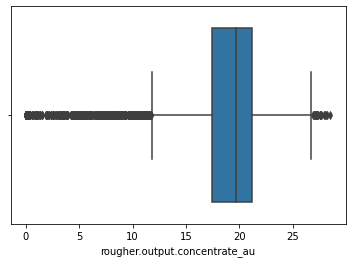

In [10]:
#boxplot 'rougher.output.concentrate_au'
sns.boxplot(df_train['rougher.output.concentrate_au']);


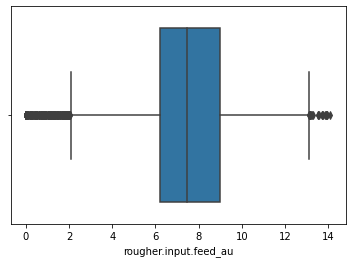

In [11]:
#boxplot 'rougher.input.feed_au'
sns.boxplot(df_train['rougher.input.feed_au']);

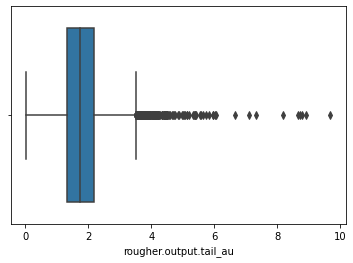

In [12]:
#boxplot 'rougher.output.tail_au'
sns.boxplot(df_train['rougher.output.tail_au']);

In [13]:
#dataset shape
df_train.shape

(16860, 87)

= Training Dataset = 

Findings : 
- dataset has 16860 row and 87 columns
- there are no duplicated data
- 3 main data parameter on gold recovery formula has missing values as follows:
  1. rougher.output.concentrate_au :  82
  2. rougher.input.feed_au :  83
  3. rougher.output.tail_au :  2249

Insight :
- missing value should be handled prior the calculation start
- missing value will be filled with median values

##### df_test dataset

In [14]:
#check test dataset 
df_test.head(2)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.39673,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.08,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.63081,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438


In [15]:
#dataset shape
df_test.shape

(5856, 53)

In [16]:
print ('total columns with missing value :', len(df_test.isnull().sum()))
df_test.isnull().sum()

total columns with missing value : 53


date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


In [17]:
#check duplicated dataset
df_test.duplicated().sum()

0

In [18]:
#decribe dataset
df_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5816.000000,5834.000000,5789.000000,5840.000000,5599.000000,5733.000000,5801.000000,5503.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5839.000000,5840.000000,5836.000000,5840.000000,5833.000000,5840.000000,5822.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,1486.398557,-510.723606,8.736170,3.552722,458.485472,55.937535,35.105834,8.700930,13.439933,6.169553,13.056047,6.423566,1016.294703,-404.977728,1270.598553,-482.154567,1253.495045,-480.945868,1169.675564,-482.152253,1018.386311,-476.551547,962.005375,-477.795380,25.479808,-513.714941,21.083475,-512.325717,24.345831,-519.417733,20.068079,-515.028316,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,313.725248,65.417633,2.985805,1.326113,155.958272,22.724254,10.793249,2.803046,3.997715,1.673606,4.533948,1.120371,226.494775,100.953782,285.247715,55.399631,290.703157,53.759053,285.407244,54.967985,231.675756,67.002595,220.862435,68.342305,5.450424,62.448366,5.940017,63.376776,7.950733,73.968109,7.644391,60.457838,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,0.000000,-799.838846,0.000000,0.000000,0.002986,0.046369,0.000000,0.000000,0.000154,0.000052,0.000014,0.000055,-0.123194,-657.949759,-0.821921,-650.349159,-0.282087,-650.000000,-1.047388,-648.390665,-2.076798,-650.152533,-2.593390,-650.034631,0.000000,-799.608557,0.000000,-798.467243,0.000000,-799.7

Testing Dataset =>

Findings :
- dataset has 5856 row and 53 columns
- there are no duplicated data
- all columns has missing value

##### df_source Source data

In [19]:
#check dataset 
df_source.head(2)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.37500,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.89366,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.49

In [20]:
#dataset shape
df_source.shape

(22716, 87)

In [21]:
#check null value
df_source.isnull().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

In [22]:
#check duplicated dataset
df_source.duplicated().sum()

0

In [23]:
print ('total columns with missing value :', len(df_source.isnull().sum()))
df_source.isnull().sum()

total columns with missing value : 87


date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

In [24]:
#decribe dataset
df_source.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,21170.000000,22716.000000,21565.000000,22618.000000,22268.000000,21918.000000,22618.000000,22614.000000,22594.000000,22365.000000,22617.000000,22660.000000,22667.000000,22660.000000,22673.000000,22662.000000,22673.000000,22661.000000,22673.000000,2.267200e+04,2.267200e+04,2.267200e+04,21089.000000,22618.000000,22472.000000,22163.000000,22277.000000,22357.000000,22617.000000,21415.000000,22247.000000,22038.000000,20459.000000,22618.000000,22618.000000,22526.000000,22618.000000,19597.000000,19979.000000,22618.000000,19980.000000,19980.000000,22646.000000,22647.000000,22646.000000,22647.000000,22646.000000,22654.000000,22641.000000,22649.000000,22096.000000,22649.000000,22641.000000,22642.000000,22616.000000,22600.000000,20501.000000,22618.000000,22333.000000,22591.000000,22538.000000,22588.000000,22585.000000,22587.000000,22592.000000,22590.000000,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615

Source Dataset =>

Findings :
- dataset has 22716 row and 87 columns
- there are no duplicated data
- all columns has missing value


#### Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between calculation and the feature values. describe findings

In [25]:
#defined calculation formula

def recovery_calc(row):
    numerator = row['rougher.output.concentrate_au']*(row['rougher.input.feed_au']-row['rougher.output.tail_au'])
    denominator = row ['rougher.input.feed_au']*(row['rougher.output.concentrate_au']-row['rougher.output.tail_au'])
    return numerator/denominator*100

In [26]:
#copy training dataset
df_copy_4_formula = df_train.copy()

In [27]:
#check missing value in the copied dataset
df_copy_4_formula [['rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au']].isnull().sum()

rougher.output.concentrate_au      82
rougher.input.feed_au              83
rougher.output.tail_au           2249
dtype: int64

In [28]:
#define numerator and denominator formula
df_copy_4_formula['numerator'] = df_copy_4_formula['rougher.output.concentrate_au']*(df_copy_4_formula['rougher.input.feed_au']-df_copy_4_formula['rougher.output.tail_au'])
df_copy_4_formula['denominator'] = df_copy_4_formula ['rougher.input.feed_au']*(df_copy_4_formula['rougher.output.concentrate_au']-df_copy_4_formula['rougher.output.tail_au'])

In [29]:
#check missing value in the numerator  and denominator
df_copy_4_formula [['numerator','denominator']].isnull().sum()

numerator      2250
denominator    2250
dtype: int64

In [30]:
#filling the missing value
df_copy_4_formula['numerator'] = df_copy_4_formula['numerator'].fillna(0)
df_copy_4_formula['denominator'] = df_copy_4_formula['denominator'].fillna(1)

In [31]:
#grougher.output.recovery calculation formula
df_copy_4_formula['formula'] = df_copy_4_formula['numerator']/df_copy_4_formula['denominator'] * 100

In [32]:
#Find the MAE between calculation and the feature values
result = (df_copy_4_formula['formula'] - df_copy_4_formula['rougher.output.recovery']).abs().mean()

In [33]:
print ('MAE between calculation and the feature values is {}'.format(result))

MAE between calculation and the feature values is 9.303415616264301e-15


Findings :
- Different between the expected value and measured value is = 9.303415616264301e-15

Insight :
- the difference is too small means that the calculation formula is precisely correct to calculate the true result

#### Analyze the features who are not available in the test set

In [34]:
#Find the test dataset missing columns in the train dataset
missing_test_columns = set(list(df_train.columns.values)) - set(list(df_test.columns.values))
print('There are :',len(missing_test_columns),'Features who are not available in the test set as follows :')

missing_test_columns

There are : 34 Features who are not available in the test set as follows :


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [35]:
#checking data types of missing features
df_source[missing_test_columns].dtypes

rougher.calculation.floatbank10_sulfate_to_au_feed    float64
final.output.recovery                                 float64
final.output.tail_pb                                  float64
primary_cleaner.output.concentrate_sol                float64
final.output.tail_au                                  float64
rougher.output.concentrate_ag                         float64
final.output.tail_ag                                  float64
secondary_cleaner.output.tail_ag                      float64
final.output.concentrate_au                           float64
rougher.calculation.au_pb_ratio                       float64
primary_cleaner.output.tail_ag                        float64
primary_cleaner.output.concentrate_pb                 float64
rougher.output.tail_pb                                float64
primary_cleaner.output.tail_pb                        float64
final.output.concentrate_sol                          float64
rougher.output.tail_au                                float64
rougher.

Findings :
- total 34 test set features are not available
- all missing features/columns have float data types


#### Data preparation / engineering

In [36]:
#check total missing value in source dataset
df_source.isnull().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

In [37]:
#check mean of missing value columns in source dataset
print ('There are',len(df_source.isnull().mean().sort_values(ascending=False)),
       'missing values columns in source dataset and the mean as follows :')
df_source.isnull().mean().sort_values(ascending=False)

There are 87 missing values columns in source dataset and the mean as follows :


rougher.output.recovery                     0.137304
rougher.output.tail_ag                      0.120488
rougher.output.tail_au                      0.120444
rougher.output.tail_sol                     0.120444
rougher.input.floatbank11_xanthate          0.099357
                                              ...   
primary_cleaner.state.floatbank8_b_level    0.001893
primary_cleaner.state.floatbank8_c_level    0.001893
primary_cleaner.state.floatbank8_d_level    0.001893
primary_cleaner.input.feed_size             0.000000
date                                        0.000000
Length: 87, dtype: float64

In [38]:
#check mean of missing value columns in train dataset
print ('There are',len(df_train.isnull().mean().sort_values(ascending=False)),
       'missing values columns in train dataset and the mean as follows :')
df_train.isnull().mean().sort_values(ascending=False)

There are 87 missing values columns in train dataset and the mean as follows :


rougher.output.recovery                               0.152610
rougher.output.tail_ag                                0.133452
rougher.output.tail_sol                               0.133393
rougher.output.tail_au                                0.133393
secondary_cleaner.output.tail_sol                     0.117794
                                                        ...   
primary_cleaner.state.floatbank8_d_level              0.001601
rougher.calculation.floatbank10_sulfate_to_au_feed    0.001601
rougher.calculation.floatbank11_sulfate_to_au_feed    0.001601
primary_cleaner.input.feed_size                       0.000000
date                                                  0.000000
Length: 87, dtype: float64

In [39]:
#check mean of missing value columns in test dataset
print ('There are',len(df_test.isnull().mean().sort_values(ascending=False)),
       'missing values columns in test dataset and the mean as follows :')
df_test.isnull().mean().sort_values(ascending=False)

There are 53 missing values columns in test dataset and the mean as follows :


rougher.input.floatbank11_xanthate            0.060280
primary_cleaner.input.sulfate                 0.051571
primary_cleaner.input.depressant              0.048497
rougher.input.floatbank10_sulfate             0.043887
primary_cleaner.input.xanthate                0.028347
rougher.input.floatbank10_xanthate            0.021004
rougher.input.feed_sol                        0.011441
rougher.input.floatbank11_sulfate             0.009392
rougher.input.feed_rate                       0.006831
secondary_cleaner.state.floatbank3_a_air      0.005806
secondary_cleaner.state.floatbank2_b_air      0.003928
rougher.input.feed_size                       0.003757
secondary_cleaner.state.floatbank2_a_air      0.003415
rougher.state.floatbank10_a_air               0.002903
rougher.state.floatbank10_c_air               0.002903
rougher.state.floatbank10_d_air               0.002903
rougher.state.floatbank10_e_air               0.002903
rougher.state.floatbank10_b_air               0.002903
rougher.st

Findings:
- all datasets have missing values:
  - source dataset has 87  missing values
  - train dataset has 87 missing values
  - test dataset has 53 missing values

Insight :
- all missing values will be filled with median values

### Analyze the data

#### Make a notes regarding how the concentration of metals (Au, Ag, Pb) changes depending on the purification stage

In [40]:
steps_template = [
    'rougher.input.feed_{}',
    'rougher.output.concentrate_{}',
    'primary_cleaner.output.concentrate_{}',
    'final.output.concentrate_{}',
]
def plot_concentrate_progress (component):
    steps = [s.format(component)for s in steps_template]
    for step in steps:
        df_source[step].hist(alpha=0.5, bins=20)
        plt.legend(steps)

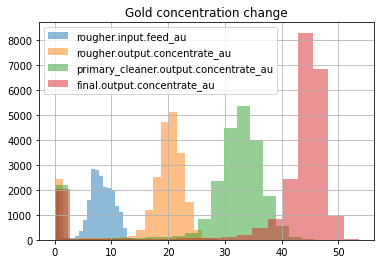

In [41]:
plot_concentrate_progress('au')
plt.title ('Gold concentration change');

note :
- the purification of gold is sequential from rougher input, rougher ouput, primary cleaner and become final output
- the concentration of gold is become higher in every stage of purification

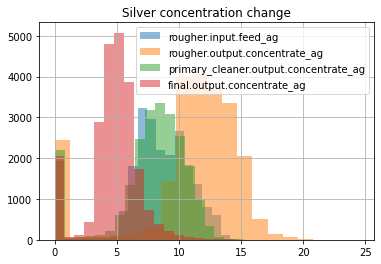

In [42]:
plot_concentrate_progress('ag')
plt.title ('Silver concentration change');

note :
- the purification of Silver showing that  sequential from left to right is final output, primary cleaner and rougher input in the same stage and rougher output is the last
- the concentration of silver is become higher in every stage of purification

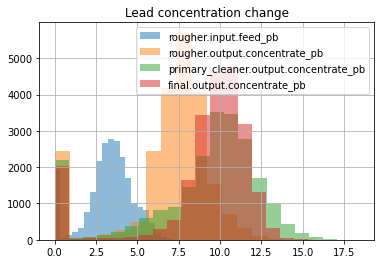

In [43]:
plot_concentrate_progress('pb')
plt.title ('Lead concentration change');

note :
- the purification of Lead showing that  sequential from left to right is rougher input, rougher output, primary cleaner and final output in the same stage
- the highet concetration of lead is in the rougher output statge

#### Compare the feed particle size distribution in training sets as well as in test sets. 

In [44]:
#funtion to filter the outliers
def filter_outliers (series):
    return series [series.between(series.quantile(0.01), series.quantile(0.99))]

#define function to check distribution the feed in the train and test set
def compare_train_test_features (feature):
    filter_outliers(df_train[feature]).plot.kde()
    filter_outliers(df_test[feature]).plot.kde()
    plt.legend (['train', 'test'])
    

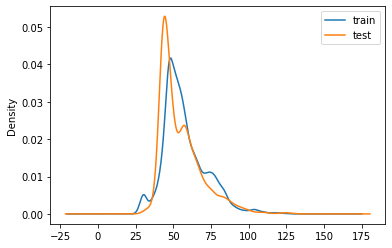

In [45]:
#plotting the distribution of rougher.input.feed_size with outliers removed
compare_train_test_features('rougher.input.feed_size')

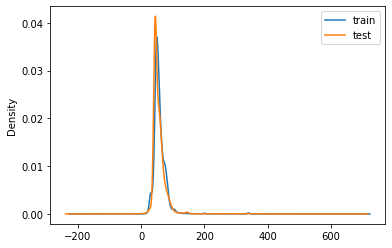

In [46]:
#plotting the distribution of rougher.input.feed_size without removing the outliers
df_train['rougher.input.feed_size'].plot.kde();
df_test['rougher.input.feed_size'].plot.kde();
plt.legend (['train', 'test'])

Findings :
- both distribution ( with outliers filtered or withour filtered ) are similar 

Insight :
- we can proceed and analyze further due to the distribution difference are not significant

#### Consider the total concentration of all substances at different stages: raw feed, coarser concentration, and final concentration. Do you notice any abnormal values in the total distribution? If so, is it necessary to remove those values from both samples? Describe what you found and get rid of the anomaly.

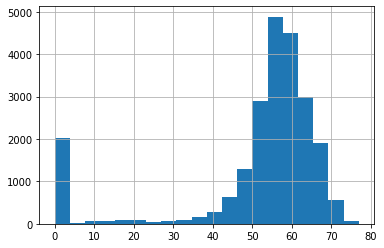

In [47]:
#raw feed substance
features_input_concentrate = [
    'rougher.input.feed_au',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol'
]

df_source[features_input_concentrate].sum(1).hist(bins=20);

note :
- total concentration during raw feed stage has abnormal value

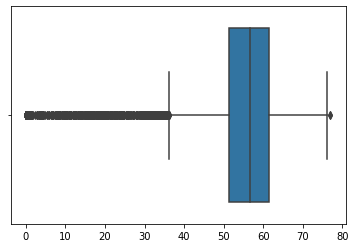

In [48]:
#plotting the substance row feed
sns.boxplot(df_source[features_input_concentrate].sum(1));

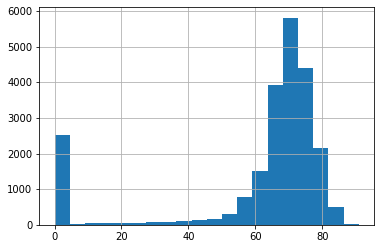

In [49]:
#coarser concentration substance
features_rough_concentrate = [
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol'
]

df_source[features_rough_concentrate].sum(1).hist(bins=20);

note :
- total coarser concentration stage has abnormal value

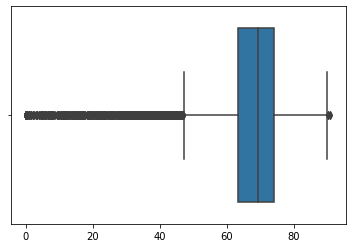

In [50]:
#plotting coarser concentration substance
sns.boxplot(df_source[features_rough_concentrate].sum(1));

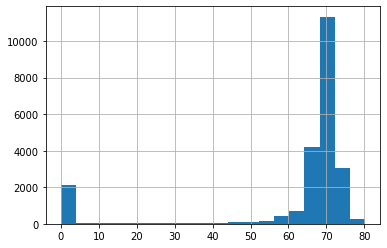

In [51]:
#final concentration substance
features_final_concentrate = [
    'final.output.concentrate_au',
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol'
]

df_source[features_final_concentrate].sum(1).hist(bins=20);

note :
- total final concentration stage has abnormal value

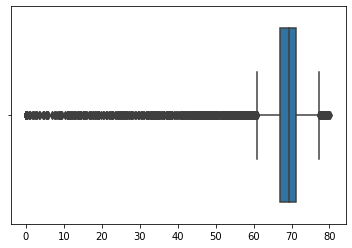

In [52]:
#plotting final concentration substance
sns.boxplot(df_source[features_final_concentrate].sum(1));

In [53]:
#handling anomaly value
threshold = 0.1

df_train = df_train[df_train[features_input_concentrate].sum(1) > threshold]
df_train = df_train[df_train[features_rough_concentrate].sum(1) > threshold]
df_train = df_train[df_train[features_final_concentrate].sum(1) > threshold]
print (df_train.shape)

df_source_test = df_source[df_source['date'].isin(df_test['date'])].reset_index(drop=True)

df_test = df_test[df_source_test[features_input_concentrate].sum(1) > threshold]
df_test = df_test[df_source_test[features_rough_concentrate].sum(1) > threshold]
df_test = df_test[df_source_test[features_final_concentrate].sum(1) > threshold]
print (df_test.shape)

(14601, 87)
(5277, 53)


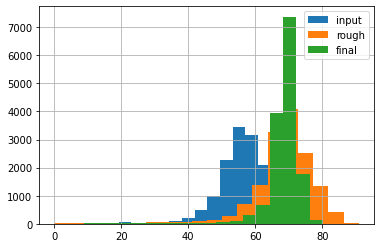

In [54]:
#plotting substance after handling abnormal value
df_train[features_input_concentrate].sum(1).hist(bins=20);
df_train[features_rough_concentrate].sum(1).hist(bins=20);
df_train[features_final_concentrate].sum(1).hist(bins=20);
plt.legend (['input', 'rough','final']);

note :
- abnormal value in all stage already removed

#### Handling missing value

In [55]:
#append missing columns in dataset
columns_used = df_test.columns.values.tolist()
columns_used.append('rougher.output.recovery')
columns_used.append('final.output.recovery')

In [56]:
# added rougher.output.recovery and final.output.recovery into train dataset
df_train_fixed = df_train[columns_used]

In [57]:
#resetting index in train dataset
df_train_fixed = df_train_fixed[df_train_fixed['rougher.output.recovery'].notnull()].reset_index(drop=True)
df_train_fixed = df_train_fixed[df_train_fixed['final.output.recovery'].notnull()].reset_index(drop=True)

In [58]:
#check train and test dataset row and columns
df_train_fixed.shape, df_test.shape

((13789, 55), (5277, 53))

In [59]:
#combine train and test dataset tobe source dataset
df_source_fixed = pd.concat([df_train_fixed,df_test])

In [60]:
#check source fixed dataset row and columns
df_source_fixed.shape

(19066, 55)

In [61]:
#check missing value with mean in source_fixed dataset
df_source_fixed.isnull().mean().sort_values(ascending=False)

final.output.recovery                         0.276775
rougher.output.recovery                       0.276775
rougher.input.floatbank11_xanthate            0.022186
rougher.state.floatbank10_e_air               0.019564
secondary_cleaner.state.floatbank2_a_air      0.011329
rougher.input.feed_size                       0.007343
rougher.input.feed_pb                         0.005245
rougher.input.feed_sol                        0.005192
primary_cleaner.input.xanthate                0.005088
rougher.input.floatbank10_sulfate             0.001836
rougher.input.floatbank11_sulfate             0.001678
primary_cleaner.input.depressant              0.001521
primary_cleaner.input.sulfate                 0.001101
secondary_cleaner.state.floatbank2_b_air      0.001049
rougher.input.feed_rate                       0.000734
secondary_cleaner.state.floatbank3_a_air      0.000629
rougher.input.floatbank10_xanthate            0.000420
secondary_cleaner.state.floatbank4_a_air      0.000210
primary_cl

In [62]:
#define function to filling the missing value with median
for cols in df_source_fixed.isnull().mean().sort_values(ascending=False)[2:-2].index:
    median_cols = df_source_fixed[cols].median()
    df_source_fixed[cols] = df_source_fixed[cols].fillna(median_cols)
    

In [63]:
# selecting final dataset for train and test dataset
df_test_final = df_source_fixed[df_source_fixed['rougher.output.recovery'].isnull()]
df_test_final = df_test_final.drop(columns = ['rougher.output.recovery', 'final.output.recovery'])

df_train_final = df_source_fixed[df_source_fixed['rougher.output.recovery'].notnull()].reset_index(drop=True)

In [64]:
#check final row and columns of train and test dataset
df_train_final.shape, df_test_final.shape

((13789, 55), (5277, 53))

In [65]:
#check missing value final training dataset
df_train_final.isnull().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

## Define the Model

In [66]:
#define feature and target model
features = df_test_final.drop(columns=['date']).columns.values
targets = ['rougher.output.recovery', 'final.output.recovery']

In [67]:
#define features train and target train
features_train = df_train_final[features].reset_index(drop=True)
target_train = df_train_final[targets].reset_index(drop=True)
target_train.columns = [0,1]

In [68]:
#check features train dataset
features_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001,25.880539,-499.989656,23.889530,-500.372428,23.970550,-500.085473,22.085714,-499.446897,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,1599.541515,-499.827444,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147,26.005245,-499.929616,23.886657,-499.951928,23.913535,-499.442343,23.957717,-499.901982,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,1600.449520,-500.052575,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578,999.814770,-400.200179,1600.059442,-450.619948,1600.012842,-449.910497,1597.725177,-450.130127,1400.943157,-450.030142,1400.234743,-449.790835,25.942508,-499.176749,23.955516,-499.848796,23.

In [69]:
#check target train dataset
target_train.head()

,0,1
0,87.107763,70.541216
1,86.843261,69.266198
2,86.842308,68.116445
3,87.226430,68.347543
4,86.688794,66.927016


In [70]:
#define features test
features_test = df_test_final[features].reset_index(drop=True)
features_test

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.503052,1001.930679,-400.437573,950.735324,-399.802986,24.893998,-499.382374,14.916674,-

In [71]:
#define target test
target_test = df_source[df_source['date'].isin(df_test_final['date'])][targets].reset_index(drop=True)
target_test.columns = [0,1]
target_test

,0,1
0,89.993421,70.273583
1,88.089657,68.910432
2,88.412756,68.143213
3,87.360133,67.776393
4,83.236367,61.467078
...,...,...
5272,95.172585,68.919891
5273,94.575036,68.440582
5274,93.018138,67.092759
5275,92.599042,68.061186


### Define a function to calculate the final sMAPE value.

In [72]:
#function to calculate sMAPE value
def smape(y_true,y_pred):
    error = (y_true - y_pred).abs()
    scale = (y_true.abs() + y_pred.abs()) / 2
    
    return (error / scale).mean() * 100

def smape_weighted (y_true, y_pred):
    rougher = smape(y_true[0], y_pred[0])
    final = smape(y_true[1], y_pred[1])
    
    return 0.25 * rougher + 0.75 * final

### Train on different models. Evaluate those models using cross-validation. Choose the best model and test the model using a test sample. Show me what you find

#### Baseline calculation

In [73]:
#calculate sMAPE base  on the median value
pred_median = target_train.copy()
pred_median[0] = target_train[0].median()
pred_median[1] = target_train[1].median()
print('target_train smape :', smape_weighted(target_train, pred_median))

pred_median = target_test.copy()
pred_median[0] = target_train[0].median()
pred_median[1] = target_train[1].median()
print('target_test smape :', smape_weighted(target_test, pred_median))

target_train smape : 9.448962714511023
target_test smape : 7.484290599632675


#### Cross-Validation

In [74]:
#define Cross-Validation function to evaluate models
def score_model (model, cv=4):
    scores = []
    
    for subtrain_index, valid_index in KFold(n_splits=cv).split(features_train):
        
        features_subtrain = features_train.loc[subtrain_index].reset_index(drop=True)
        target_subtrain = target_train.loc[subtrain_index].reset_index(drop=True)

        features_valid = features_train.loc[valid_index].reset_index(drop=True)
        target_valid = target_train.loc[valid_index].reset_index(drop=True)
        
        model.fit(features_subtrain, target_subtrain)
        pred_valid = pd.DataFrame(model.predict(features_valid))
        
        scores.append(smape_weighted(target_valid,pred_valid))
    return pd.Series(scores).mean()

#### Train the Models

In [75]:
#LinearRegression method
model = LinearRegression()
lr_score = score_model (model)
print('LinearRegression :',lr_score )

LinearRegression : 10.245182590730153


In [76]:
#RandomForest method
for depth in range (1,6):
    model = RandomForestRegressor(max_depth=depth, n_estimators=50,random_state=12345)
    score = score_model(model)
    print ('RandomForest, depth :', depth, 'score :', score)

RandomForest, depth : 1 score : 10.187372474659732
RandomForest, depth : 2 score : 9.829588870943546
RandomForest, depth : 3 score : 9.445174093920482
RandomForest, depth : 4 score : 9.480773245266615
RandomForest, depth : 5 score : 9.506816773738153


In [77]:
#DecissionTree Method
for depth in [1,2,6, None]:
    dtree = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    score = score_model(model)
    print ('DecissionTree, depth :', depth, 'score :', score)

DecissionTree, depth : 1 score : 9.506816773738153
DecissionTree, depth : 2 score : 9.506816773738153
DecissionTree, depth : 6 score : 9.506816773738153
DecissionTree, depth : None score : 9.506816773738153


#### Test the model using Test sample

Based on the previous models training, we have RandomForest with depth 3 is the best model

In [78]:
#evaluate the model using test sample

model = RandomForestRegressor(max_depth=3, n_estimators=50,random_state=12345)
model.fit(features_train, target_train)

pred = pd.DataFrame(model.predict(features_train))
print('train:', smape_weighted(target_train,pred))

pred = pd.DataFrame(model.predict(features_test))
print('test:',smape_weighted(target_test,pred) )

train: 7.493802997004302
test: 7.303130492842537


## Conclussion

Based on the data provided from Zyfra company, we got several point during gold purification processes:
- the purification of gold is sequential from rougher input, rougher ouput, primary cleaner and become final output
- the concentration of gold is become higher in every stage of purification
- the purification of Silver showing that  sequential from left to right is final output, primary cleaner and rougher input in the same stage and rougher output is the last
- the concentration of silver is become higher in every stage of purification
- the purification of Lead showing that  sequential from left to right is rougher input, rougher output, primary cleaner and final output in the same stage
- the highet concetration of lead is in the rougher output statge
- both :
  - rougher.output.recovery'
  - final.output.recovery
  are missing values on train and test dataset and already filled with the median values
- model has been evaluated with cross-validation method with result as follows
  - LinearRegression : 10.245182590730153
  - RandomForest, depth : 3 score : 9.445174093920482
  - DecissionTree, depth : 2 score : 9.50681677373815
  and we come up with the RandomForest regression method to check the final result with test dataset
- below result is RandomForest regression predict with :
  - train dataset = 7.493802997004302 
  - test dataset = 7.303130492842537
  
  these values are betters than the baseline value
- RandomForest with depth 3, n_estimators = 50 is the best model to calculate the recovery of gold 